# LP für gemischt-ganzzahlige Optimierungsprobleme (MILP)
(Mixed-Integer Linear Program)

**HiGHS**

- Exakter Solver (Branch-and-Bound)
- HiGHS löst dein MILP per Simplex/Barrier‐Verfahren plus Branch-and-Bound.
- Wenn der Solver bis zum Time‐Limit läuft, liefert er eine (provably) optimale oder zumindest pareto‐optimale Lösung mit einer nachgewiesenen Lücke (Optimality Gap).

## Minimierung der Flow Times der einzelnen Jobs

In [4]:
import pulp
import pandas as pd

### a) Ungewichtet

In [6]:
#  ungewichtet
def solve_jssp_individual_flowtime(job_dict, df_arrivals, solver_time_limit=300, epsilon=0.00):
    """
    Minimiert die Summe der individuellen Durchlaufzeiten (Flow Times) aller Jobs.
    Zielfunktion: sum_j [ Endzeit_j - Ankunftszeit_j ]

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals: DataFrame mit Spalten "Job" und "Arrival"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    # Ankunftszeiten als Dictionary
    df_arrivals = df_arrivals.sort_values("Arrival").reset_index(drop=True)
    arrival_times = df_arrivals.set_index("Job")["Arrival"].to_dict()

    # Jobnamen nach Ankunftszeit sortieren (absteigend)
    job_names = list(df_arrivals.sort_values("Arrival", ascending=False)["Job"])

    num_jobs = len(job_names)
    all_ops = [job_dict[job] for job in job_names]
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem
    prob = pulp.LpProblem("JobShop_Total_FlowTime", pulp.LpMinimize)

    # Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    # Zielfunktion: ungeeichtete Summe aller Flow Times
    prob += pulp.lpSum([
        job_ends[j] - arrival_times[job_names[j]]
        for j in range(num_jobs)
    ])

    # Technologische Reihenfolge & Ankunftszeit
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (Disjunktivität)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Endzeit jeder Job = Ende letzter Operation
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # Solver starten
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Zeitplan extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Flow time"] = df_schedule["End"] - df_schedule["Arrival"]

    df_schedule = df_schedule[["Job", "Arrival", "Machine", "Start", "Processing Time", "Flow time", "End"]]

    total_flowtime = round(pulp.value(prob.objective), 3)
    return df_schedule, total_flowtime

### b) Gewichtet

In [8]:
def solve_jssp_weighted_individual_flowtime(job_dict, df_arrivals, solver_time_limit=300, epsilon=0.00):
    """
    Minimiert die gewichtete Summe der individuellen Durchlaufzeiten (Flow Times) aller Jobs.
    Gewichtung bevorzugt früh ankommende Jobs.

    Gewicht_j = 1 / (1 + Ankunftszeit_j)
    Zielfunktion: sum_j [ Gewicht_j * (Endzeit_j - Ankunftszeit_j) ]

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals: DataFrame mit Spalten "Job" und "Arrival"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    # Ankunftszeiten als Dictionary
    df_arrivals = df_arrivals.sort_values("Arrival").reset_index(drop=True)
    arrival_times = df_arrivals.set_index("Job")["Arrival"].to_dict()

    # Jobnamen nach Ankunftszeit sortieren (absteigend)
    job_names = list(df_arrivals.sort_values("Arrival", ascending=False)["Job"])

    num_jobs = len(job_names)

    # Operationen in Ankunftsreihenfolge
    all_ops = [job_dict[job] for job in job_names]

    # Maschinen extrahieren
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem
    prob = pulp.LpProblem("JobShop_Weighted_Total_FlowTime", pulp.LpMinimize)

    # Startzeitvariablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    # Endzeitvariablen je Job
    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    # Gewichtung: frühere Ankunft = höhere Priorität
    weights = {j: 1 / (1 + arrival_times[job_names[j]]) for j in range(num_jobs)}

    # Zielfunktion: gewichtete Durchlaufzeiten minimieren
    prob += pulp.lpSum([
        weights[j] * (job_ends[j] - arrival_times[job_names[j]])
        for j in range(num_jobs)
    ])

    # Technologische Reihenfolge + Ankunft
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Endzeit je Job = Ende letzter Operation
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # Solver
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Ergebnisse extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)

    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Flow time"] = df_schedule["End"] - df_schedule["Arrival"]

    df_schedule = df_schedule[["Job", "Arrival", "Machine", "Start", "Processing Time", "Flow time", "End"]]

    # Gesamtzielwert
    total_weighted_flowtime = round(pulp.value(prob.objective), 3)

    return df_schedule, total_weighted_flowtime

### --------------------------------------------------------------------------

In [10]:
import sys, json
from pathlib import Path

# 1. Projekt-Root nur einmal bestimmen
PROJECT_ROOT = Path.cwd().parent.resolve()

# 2. sys.path fürs Importieren um PROJECT_ROOT erweitern
sys.path.insert(0, str(PROJECT_ROOT))

In [11]:
import pandas as pd
import utils.checker as check
import utils.presenter as show
import utils.schedule_interarrival as sit

In [12]:
data_file = Path(PROJECT_ROOT, "data/jobshop_instances.json")
# Datei laden
with open(data_file, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [13]:
u_b_mmax = 0.9  # 90% Auslastung (der Engpassmaschine)

mean_interarrival_time = sit.calculate_mean_interarrival_time(instance, u_b_mmax)
print(f"Mittlere Zwischenankunftszeit (bei Auslastung von {u_b_mmax:.0%}): {mean_interarrival_time} Minuten")
df_arrivals = sit.generate_job_arrivals_df_by_mean_interarrival_time(instance, t_a=mean_interarrival_time)
df_arrivals

Mittlere Zwischenankunftszeit (bei Auslastung von 90%): 70.11 Minuten


,Job,Arrival
0,job 0,0.00
1,job 1,84.93
2,job 2,106.18
3,job 3,148.31
4,job 4,185.08
5,job 5,251.37
6,job 6,312.71
7,job 7,329.63
8,job 8,344.30
9,job 9,429.20


### a) ungewichtet

In [15]:
df_schedule, _ = solve_jssp_individual_flowtime(instance, df_arrivals, solver_time_limit=600, epsilon=0)
df_schedule

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,job 9,429.2,M1,551.93,85,207.73,636.93
1,job 9,429.2,M0,636.93,13,220.73,649.93
2,job 9,429.2,M2,649.93,61,281.73,710.93
3,job 9,429.2,M6,744.93,7,322.73,751.93
4,job 9,429.2,M8,840.93,64,475.73,904.93
...,...,...,...,...,...,...,...
95,job 0,0.0,M5,201.00,11,212.00,212.00
96,job 0,0.0,M6,212.00,62,274.00,274.00
97,job 0,0.0,M7,274.00,56,330.00,330.00
98,job 0,0.0,M8,330.00,44,374.00,374.00


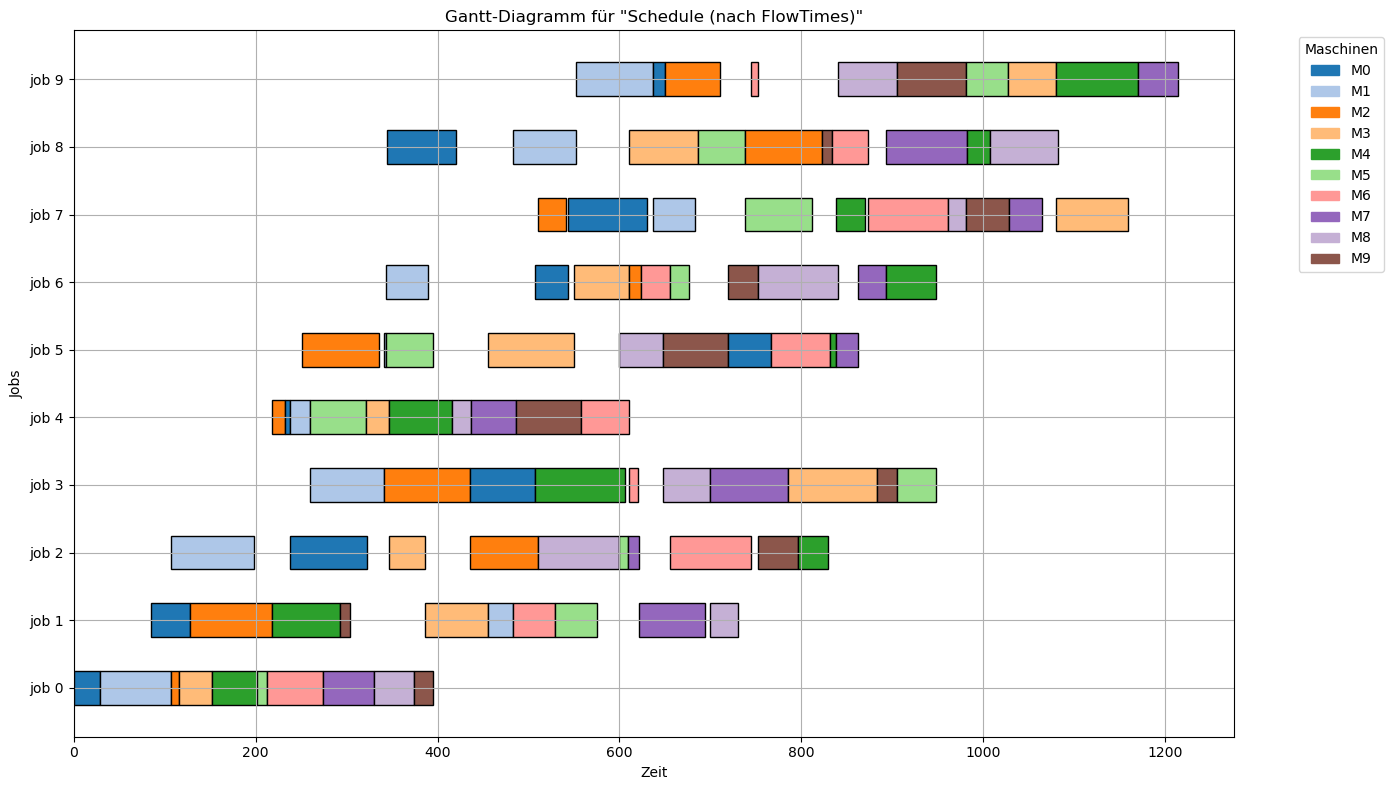

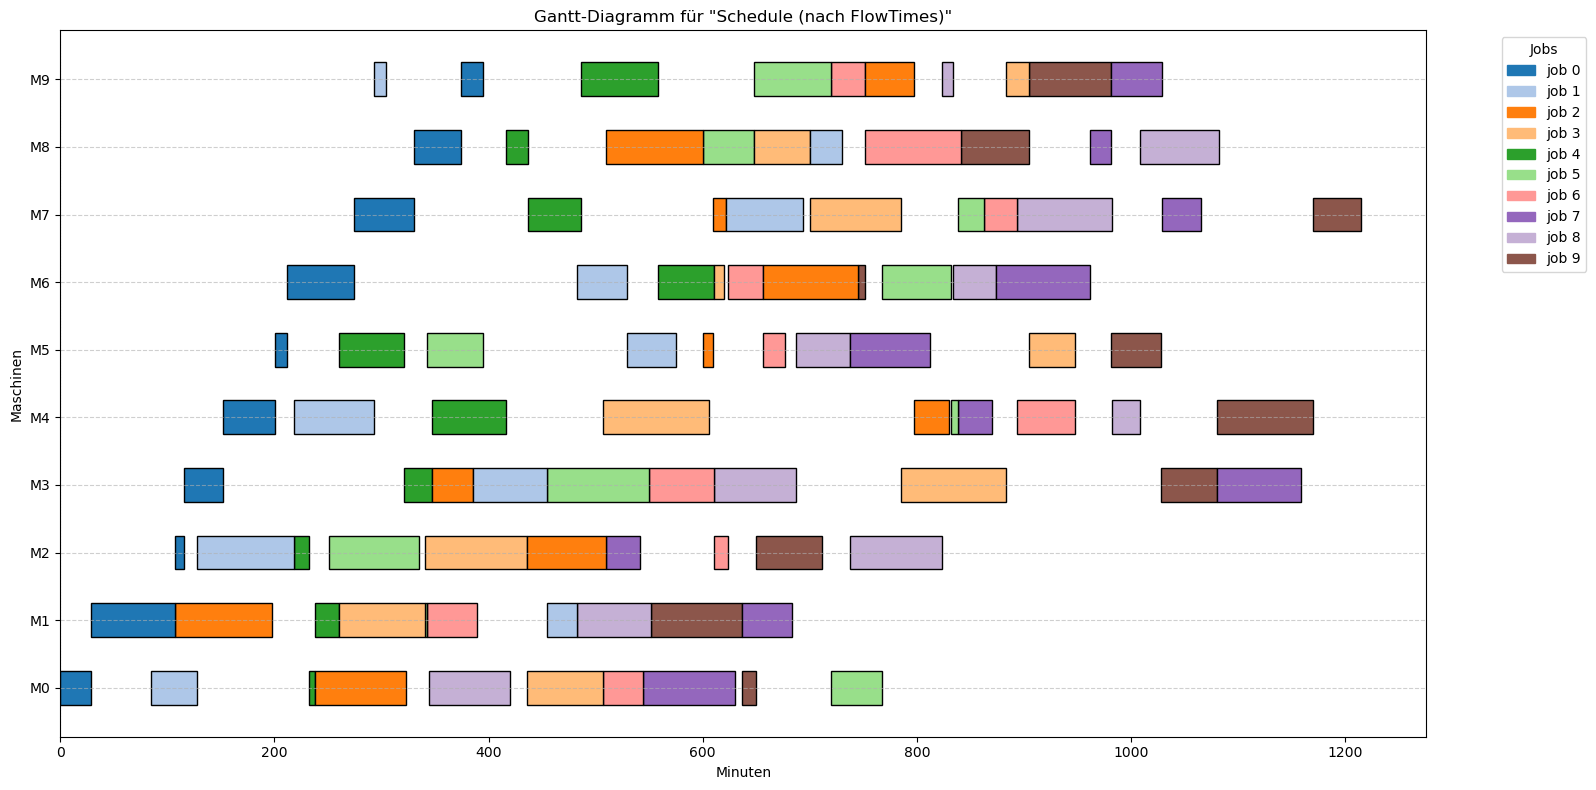

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [16]:
category = "Schedule (nach FlowTimes)"

show.plot_gantt_jobs(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_schedule, instance)

In [17]:
makespan_for_unweighted = df_schedule.End.max()
print(f"Makespan: {makespan_for_unweighted} Minuten")

Makespan: 1214.93 Minuten


> Solver-Dauer: 600.0s <br>Gap: 9.01%

### b) gewichtet

In [20]:
df_schedule, _ = solve_jssp_weighted_individual_flowtime(instance, df_arrivals, solver_time_limit=600, epsilon=0)
df_schedule

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,job 9,429.2,M1,534.0,85,189.8,619.0
1,job 9,429.2,M0,619.0,13,202.8,632.0
2,job 9,429.2,M2,632.0,61,263.8,693.0
3,job 9,429.2,M6,725.0,7,302.8,732.0
4,job 9,429.2,M8,745.0,64,379.8,809.0
...,...,...,...,...,...,...,...
95,job 0,0.0,M5,201.0,11,212.0,212.0
96,job 0,0.0,M6,212.0,62,274.0,274.0
97,job 0,0.0,M7,274.0,56,330.0,330.0
98,job 0,0.0,M8,330.0,44,374.0,374.0


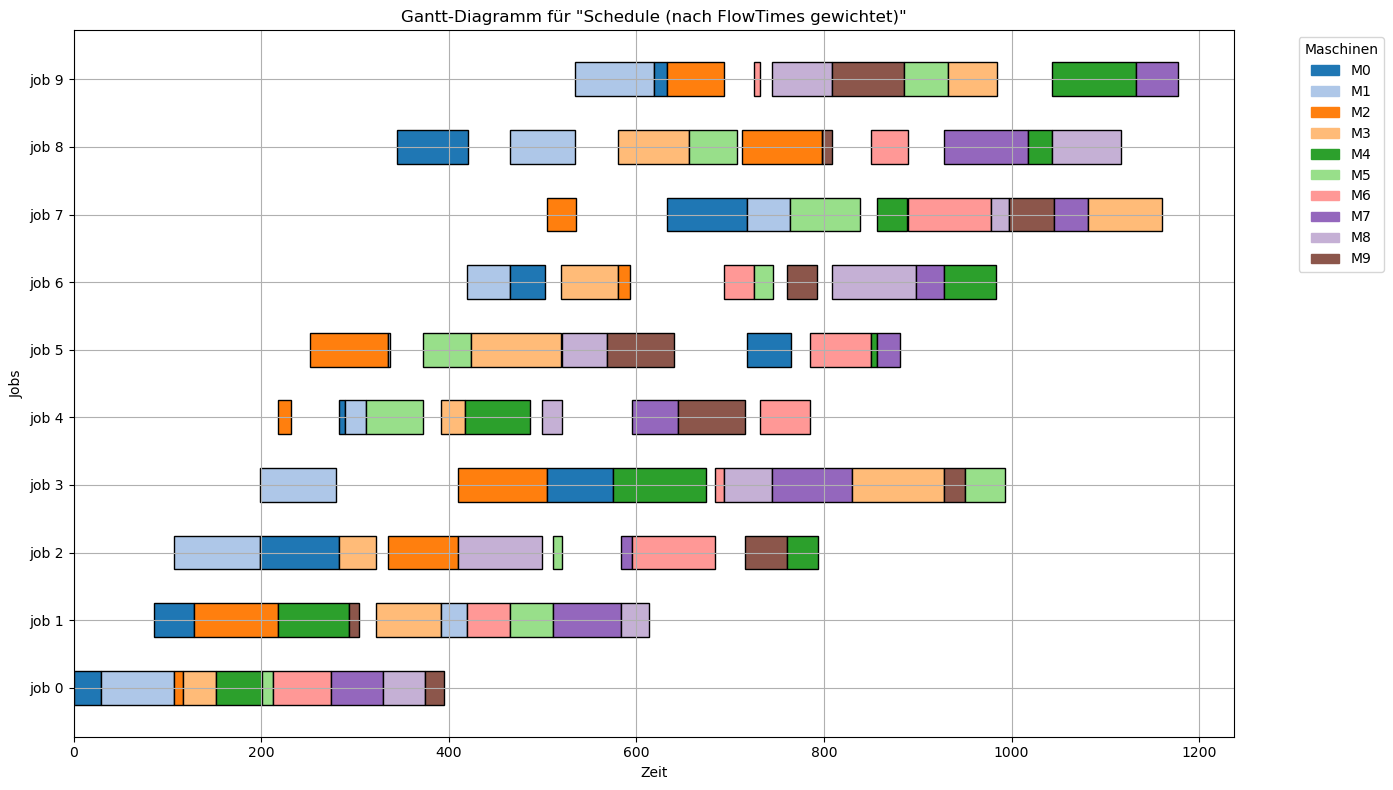

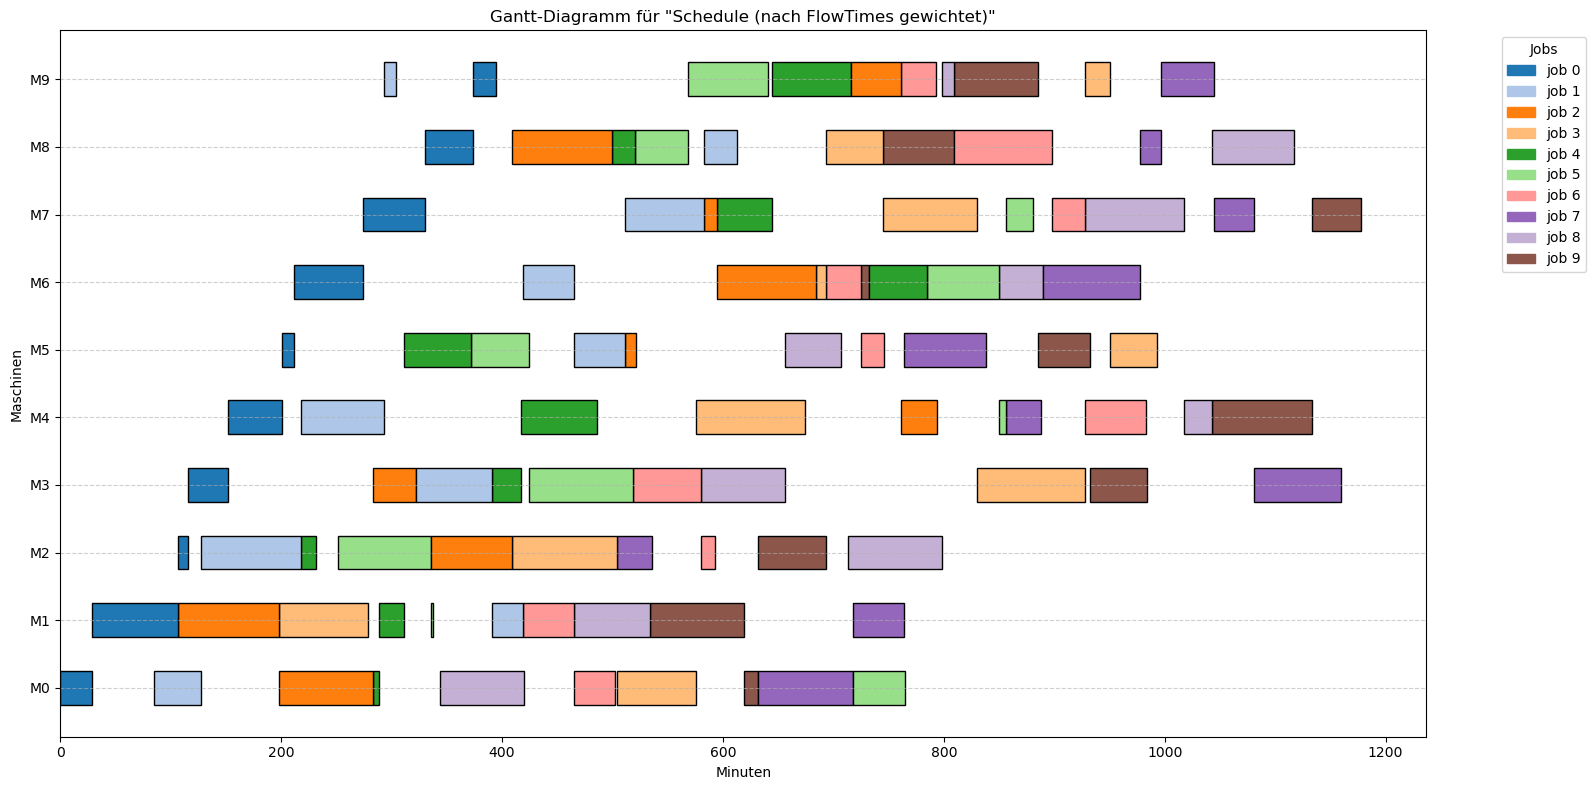

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [21]:
category = "Schedule (nach FlowTimes gewichtet)"

show.plot_gantt_jobs(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_schedule, instance)

In [22]:
makespan_for_weighted = df_schedule.End.max()
print(f"Makespan (bei gewichteten Scheduling): {makespan_for_weighted} Minuten")

Makespan (bei gewichteten Scheduling): 1178.0 Minuten


> Solver-Dauer: 600.0s <br>Gap: 0.74%